<a href="https://colab.research.google.com/github/sauravakolia/Neural-Style-Transfer/blob/master/NeuralStyleTransfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>




**Neural Style Transfer
**

 This algorithm was created by[ Gatys et al](https://arxiv.org/abs/1508.06576). (2015)


In [6]:
import os
import sys
import scipy.io
import scipy.misc
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from matplotlib.pyplot import imread
from PIL import Image
import imageio
from nst_utils import *
import numpy as np
import tensorflow as tf
import pprint
%matplotlib inline

In [2]:
!git clone https://github.com/sauravakolia/deeplearning.ai.git 


Cloning into 'deeplearning.ai'...
remote: Enumerating objects: 679, done.
remote: Total 679 (delta 0), reused 0 (delta 0), pack-reused 679
Receiving objects: 100% (679/679), 40.56 MiB | 36.60 MiB/s, done.
Resolving deltas: 100% (276/276), done.


In [0]:
os.chdir('/content/deeplearning.ai/Convolutional Neural Networks/week4/ArtTrans')

if(not(os.path.isfile('images') and os.path.isfile('output'))):
  os.mkdir('images')
  os.mkdir('output')

Download the trained weights

In [4]:
!wget --header="Host: www.vlfeat.org" --header="User-Agent: Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/79.0.3945.117 Safari/537.36" --header="Accept: text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.9" --header="Accept-Language: en-US,en;q=0.9" "http://www.vlfeat.org/matconvnet/models/imagenet-vgg-verydeep-19.mat" -O "imagenet-vgg-verydeep-19.mat" -c

--2020-01-19 09:57:29--  http://www.vlfeat.org/matconvnet/models/imagenet-vgg-verydeep-19.mat
Resolving www.vlfeat.org (www.vlfeat.org)... 64.90.48.57
Connecting to www.vlfeat.org (www.vlfeat.org)|64.90.48.57|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 534904783 (510M)
Saving to: ‘imagenet-vgg-verydeep-19.mat’

imagenet-vgg-veryde 100%[===================>] 510.12M  55.4MB/s    in 9.5s    

2020-01-19 09:57:38 (53.8 MB/s) - ‘imagenet-vgg-verydeep-19.mat’ saved [534904783/534904783]



**Problem Statement**

Neural Style Transfer (NST) is one of the most fun techniques in deep learning. As seen below, it merges two images, namely: a "content" image (C) and a "style" image (S), to create a "generated" image (G).

The generated image G combines the "content" of the image C with the "style" of image S.

In this example, we are going to generate an image of the Louvre museum in Paris (content image C), mixed with a painting by Claude Monet, a leader of the impressionist movement (style image S).

<img src="images/louvre_generated.png" style="width:750px;height:200px;">


 **Transfer Learning**
 
 we will use the VGG network.

In [7]:
pp = pprint.PrettyPrinter(indent=4)
model = load_vgg_model("imagenet-vgg-verydeep-19.mat")
pp.pprint(model)



{   'avgpool1': <tf.Tensor 'AvgPool:0' shape=(1, 150, 200, 64) dtype=float32>,
    'avgpool2': <tf.Tensor 'AvgPool_1:0' shape=(1, 75, 100, 128) dtype=float32>,
    'avgpool3': <tf.Tensor 'AvgPool_2:0' shape=(1, 38, 50, 256) dtype=float32>,
    'avgpool4': <tf.Tensor 'AvgPool_3:0' shape=(1, 19, 25, 512) dtype=float32>,
    'avgpool5': <tf.Tensor 'AvgPool_4:0' shape=(1, 10, 13, 512) dtype=float32>,
    'conv1_1': <tf.Tensor 'Relu:0' shape=(1, 300, 400, 64) dtype=float32>,
    'conv1_2': <tf.Tensor 'Relu_1:0' shape=(1, 300, 400, 64) dtype=float32>,
    'conv2_1': <tf.Tensor 'Relu_2:0' shape=(1, 150, 200, 128) dtype=float32>,
    'conv2_2': <tf.Tensor 'Relu_3:0' shape=(1, 150, 200, 128) dtype=float32>,
    'conv3_1': <tf.Tensor 'Relu_4:0' shape=(1, 75, 100, 256) dtype=float32>,
    'conv3_2': <tf.Tensor 'Relu_5:0' shape=(1, 75, 100, 256) dtype=float32>,
    'conv3_3': <tf.Tensor 'Relu_6:0' shape=(1, 75, 100, 256) dtype=float32>,
    'conv3_4': <tf.Tensor 'Relu_7:0' shape=(1, 75, 100, 256)

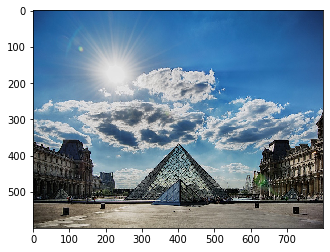

In [9]:
# !pip install pillow
# import scipy.misc
content_image = imread("images/louvre.jpg")
imshow(content_image);

The content image (C) shows the Louvre museum's pyramid surrounded by old Paris buildings, against a sunny sky with a few clouds.

** 3.1.1 - Make generated image G match the content of image C**

#### Shallower versus deeper layers
* The shallower layers of a ConvNet tend to detect lower-level features such as edges and simple textures.
* The deeper layers tend to detect higher-level features such as more complex textures as well as object classes. 

#### Choose a "middle" activation layer $a^{[l]}$
We would like the "generated" image G to have similar content as the input image C. Suppose you have chosen some layer's activations to represent the content of an image. 
* In practice, you'll get the most visually pleasing results if you choose a layer in the **middle** of the network--neither too shallow nor too deep. 
* (After you have finished this exercise, feel free to come back and experiment with using different layers, to see how the results vary.)

#### Forward propagate image "C"
* Set the image C as the input to the pretrained VGG network, and run forward propagation.  
* Let $a^{(C)}$ be the hidden layer activations in the layer you had chosen. (In lecture, we had written this as $a^{[l](C)}$, but here we'll drop the superscript $[l]$ to simplify the notation.) This will be an $n_H \times n_W \times n_C$ tensor.

#### Forward propagate image "G"
* Repeat this process with the image G: Set G as the input, and run forward progation. 
* Let $a^{(G)}$ be the corresponding hidden layer activation. 

#### Content Cost Function $J_{content}(C,G)$
We will define the content cost function as:

$$J_{content}(C,G) =  \frac{1}{4 \times n_H \times n_W \times n_C}\sum _{ \text{all entries}} (a^{(C)} - a^{(G)})^2\tag{1} $$

* Here, $n_H, n_W$ and $n_C$ are the height, width and number of channels of the hidden layer you have chosen, and appear in a normalization term in the cost. 
* For clarity, note that $a^{(C)}$ and $a^{(G)}$ are the 3D volumes corresponding to a hidden layer's activations. 
* In order to compute the cost $J_{content}(C,G)$, it might also be convenient to unroll these 3D volumes into a 2D matrix, as shown below.
* Technically this unrolling step isn't needed to compute $J_{content}$, but it will be good practice for when you do need to carry out a similar operation later for computing the style cost $J_{style}$.

<img src="images/NST_LOSS.png" style="width:800px;height:400px;">

In [0]:
# GRADED FUNCTION: compute_content_cost

def compute_content_cost(a_C, a_G):
    """
    Computes the content cost
    
    Arguments:
    a_C -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing content of the image C 
    a_G -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing content of the image G
    
    Returns: 
    J_content -- scalar that you compute using equation 1 above.
    """
    
    ### START CODE HERE ###
    # Retrieve dimensions from a_G (≈1 line)
    m, n_H, n_W, n_C = a_G.get_shape().as_list()
    
    # Reshape a_C and a_G (≈2 lines)
    a_C_unrolled = tf.reshape(a_C,shape=(m,(n_H*n_W),n_C))
    a_G_unrolled = tf.reshape(a_G,shape=(m,(n_H*n_W),n_C))
    
    # compute the cost with tensorflow (≈1 line)
    J_content = tf.multiply(tf.reduce_sum(tf.square(tf.subtract(a_C_unrolled,a_G_unrolled))),(1/(4*n_H*n_W*n_C)))
    ### END CODE HERE ###
    
    return J_content

### 3.2 - Computing the style cost

For our running example, we will use the following style image: 

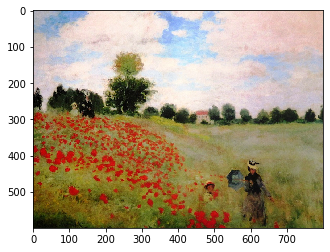

In [11]:
style_image = imread("images/monet_800600.jpg")
imshow(style_image);

### 3.2.1 - Style matrix

#### Gram matrix
* The style matrix is also called a "Gram matrix." 
* In linear algebra, the Gram matrix G of a set of vectors $(v_{1},\dots ,v_{n})$ is the matrix of dot products, whose entries are ${\displaystyle G_{ij} = v_{i}^T v_{j} = np.dot(v_{i}, v_{j})  }$. 
* In other words, $G_{ij}$ compares how similar $v_i$ is to $v_j$: If they are highly similar, you would expect them to have a large dot product, and thus for $G_{ij}$ to be large. 

#### Two meanings of the variable $G$
* Note that there is an unfortunate collision in the variable names used here. We are following common terminology used in the literature. 
* $G$ is used to denote the Style matrix (or Gram matrix) 
* $G$ also denotes the generated image. 
* we will use $G_{gram}$ to refer to the Gram matrix, and $G$ to denote the generated image.

In [0]:
# GRADED FUNCTION: gram_matrix

def gram_matrix(A):
    """
    Argument:
    A -- matrix of shape (n_C, n_H*n_W)
    
    Returns:
    GA -- Gram matrix of A, of shape (n_C, n_C)
    """
    
    ### START CODE HERE ### (≈1 line)
    GA = tf.matmul(A,tf.transpose(A))
    ### END CODE HERE ###
    
    return GA

### 3.2.2 - Style cost

```
```



 goal will be to minimize the distance between the Gram matrix of the "style" image S and the gram matrix of the "generated" image G.

For now, we are using only a single hidden layer $a^{[l]}$.
The corresponding style cost for this layer is defined as:
$$J_{style}^{[l]}(S,G) = \frac{1}{4 \times {n_C}^2 \times (n_H \times n_W)^2} \sum _{i=1}^{n_C}\sum_{j=1}^{n_C}(G^{(S)}_{(gram)i,j} - G^{(G)}_{(gram)i,j})^2\tag{2} $$

$G_{gram}^{(S)}$ Gram matrix of the "style" image.
$G_{gram}^{(G)}$ Gram matrix of the "generated" image.
Remember, this cost is computed using the hidden layer activations for a particular hidden layer in the network $a^{[l]}$


In [0]:
# GRADED FUNCTION: compute_layer_style_cost

def compute_layer_style_cost(a_S, a_G):
    """
    Arguments:
    a_S -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing style of the image S 
    a_G -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing style of the image G
    
    Returns: 
    J_style_layer -- tensor representing a scalar value, style cost defined above by equation (2)
    """
    
    ### START CODE HERE ###
    # Retrieve dimensions from a_G (≈1 line)
    m, n_H, n_W, n_C = a_G.get_shape().as_list()
    
    # Reshape the images to have them of shape (n_C, n_H*n_W) (≈2 lines)
    a_S = tf.transpose(tf.reshape(a_S,shape=((n_H*n_W),n_C)))
    a_G = tf.transpose(tf.reshape(a_G,shape=((n_H*n_W),n_C)))

    # Computing gram_matrices for both images S and G (≈2 lines)
    GS = gram_matrix(a_S)
    GG = gram_matrix(a_G)

    # Computing the loss (≈1 line)
    J_style_layer = tf.multiply(tf.reduce_sum(tf.square(tf.subtract(GS,GG))),(1/(4*n_C*n_C*n_H*n_W*n_H*n_W)))
    
    ### END CODE HERE ###
    
    return J_style_layer

### 3.2.3 Style Weights


In [0]:
STYLE_LAYERS = [
    ('conv1_1', 0.2),
    ('conv2_1', 0.2),
    ('conv3_1', 0.2),
    ('conv4_1', 0.2),
    ('conv5_1', 0.2)]

###  compute style cost

In [0]:
def compute_style_cost(model, STYLE_LAYERS):
    """
    Computes the overall style cost from several chosen layers
    
    Arguments:
    model -- our tensorflow model
    STYLE_LAYERS -- A python list containing:
                        - the names of the layers we would like to extract style from
                        - a coefficient for each of them
    
    Returns: 
    J_style -- tensor representing a scalar value, style cost defined above by equation (2)
    """
    
    # initialize the overall style cost
    J_style = 0

    for layer_name, coeff in STYLE_LAYERS:

        # Select the output tensor of the currently selected layer
        out = model[layer_name]

        # Set a_S to be the hidden layer activation from the layer we have selected, by running the session on out
        a_S = sess.run(out)

        # Set a_G to be the hidden layer activation from same layer. Here, a_G references model[layer_name] 
        # and isn't evaluated yet. Later in the code, we'll assign the image G as the model input, so that
        # when we run the session, this will be the activations drawn from the appropriate layer, with G as input.
        a_G = out
        
        # Compute style_cost for the current layer
        J_style_layer = compute_layer_style_cost(a_S, a_G)

        # Add coeff * J_style_layer of this layer to overall style cost
        J_style += coeff * J_style_layer

    return J_style

*italicized text*

Defining the total cost to optimize
Finally, let's create a cost function that minimizes both the style and the content cost. The formula is:

$$J(G) = \alpha J_{content}(C,G) + \beta J_{style}(S,G)$$

Exercise: Implement the total cost function which includes both the content cost and the style cost.

In [0]:
def total_cost(J_content, J_style, alpha = 10, beta = 40):
    """
    Computes the total cost function
    
    Arguments:
    J_content -- content cost coded above
    J_style -- style cost coded above
    alpha -- hyperparameter weighting the importance of the content cost
    beta -- hyperparameter weighting the importance of the style cost
    
    Returns:
    J -- total cost as defined by the formula above.
    """
    
    ### START CODE HERE ### (≈1 line)
#     J = tf.add(tf.multiply(tf.to_float(alpha),tf.to_float(J_content))+(tf.multiply(tf.to_float(beta),tf.to_float(J_style))))
    J= (alpha*J_content)+(beta*J_style)
#     J=np.add(np.multiply(alpha,J_content),np.multiply(beta,J_style))
    ### END CODE HERE ###
    
    return J

**Solving the optimization problem**

#### Interactive Sessions

In [0]:
# Reset the graph
tf.reset_default_graph()

# Start interactive session
sess = tf.InteractiveSession()

#### Content image


In [0]:
content_image = imread("images/louvre_small.jpg")
content_image = reshape_and_normalize_image(content_image)

#### Style image


In [0]:
style_image = imread("images/monet.jpg")
style_image = reshape_and_normalize_image(style_image)

Generated image correlated with content image
Now, we initialize the "generated" image as a noisy image created from the content_image.



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


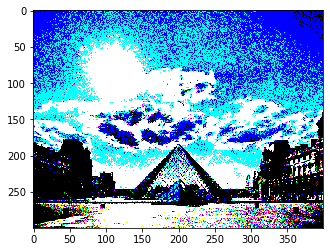

In [21]:
generated_image = generate_noise_image(content_image)
imshow(generated_image[0]);

In [0]:
model = load_vgg_model("imagenet-vgg-verydeep-19.mat")

#### Content Cost


In [0]:
# Assign the content image to be the input of the VGG model.  
sess.run(model['input'].assign(content_image))

# Select the output tensor of layer conv4_2
out = model['conv4_2']

# Set a_C to be the hidden layer activation from the layer we have selected
a_C = sess.run(out)

# Set a_G to be the hidden layer activation from same layer. Here, a_G references model['conv4_2'] 
# and isn't evaluated yet. Later in the code, we'll assign the image G as the model input, so that
# when we run the session, this will be the activations drawn from the appropriate layer, with G as input.
a_G = out

# Compute the content cost
J_content = compute_content_cost(a_C, a_G)

#### Style cost

In [0]:
# Assign the input of the model to be the "style" image 
sess.run(model['input'].assign(style_image))

# Compute the style cost
J_style = compute_style_cost(model, STYLE_LAYERS)

total cost

### START CODE HERE ### (1 line)
J = total_cost(J_content,J_style,alpha=10,beta=40)
### END CODE HERE ###

In [0]:
J = total_cost(J_content,J_style,alpha=10,beta=40)


### Optimizer


In [0]:
optimizer = tf.train.AdamOptimizer(learning_rate=2.0)

# define train_step (1 line)
train_step = optimizer.minimize(J)

In [0]:
import imageio
def save_Image(path, image):
    
    # Un-normalize the image so that it looks good
    image = image + CONFIG.MEANS
    
    # Clip  Save the image
    image = np.clip(image[0], 0, 255).astype('uint8')
    imageio.imsave(path, image)

 implement the model

In [0]:
def model_nn(sess, input_image, num_iterations = 200):
    
    # Initialize global variables (you need to run the session on the initializer)
    ### START CODE HERE ### (1 line)
    sess.run(tf.global_variables_initializer())
    ### END CODE HERE ###
    
    # Run the noisy input image (initial generated image) through the model. Use assign().
    ### START CODE HERE ### (1 line)
    model["input"].assign(input_image)
    ### END CODE HERE ###
    
    for i in range(num_iterations):
    
        # Run the session on the train_step to minimize the total cost
        ### START CODE HERE ### (1 line)
        sess.run(train_step)
        ### END CODE HERE ###
        
        # Compute the generated image by running the session on the current model['input']
        ### START CODE HERE ### (1 line)
        generated_image = sess.run(model['input'])
        ### END CODE HERE ###

        # Print every 20 iteration.
        if i%20 == 0:
            Jt, Jc, Js = sess.run([J, J_content, J_style])
            print("Iteration " + str(i) + " :")
            print("total cost = " + str(Jt))
            print("content cost = " + str(Jc))
            print("style cost = " + str(Js))
            
            # save current generated image in the "/output" directory
            save_Image("output/" + str(i) + ".png", generated_image)
    
    # save last generated image
    save_Image('output/generated_image.jpg', generated_image)
    
    return generated_image

In [29]:

model_nn(sess, generated_image)

Iteration 0 :
total cost = 7457518600.0
content cost = 16493.13
style cost = 186433840.0
Iteration 20 :
total cost = 1973229300.0
content cost = 21243.531
style cost = 49325420.0
Iteration 40 :
total cost = 926353200.0
content cost = 23913.922
style cost = 23152852.0
Iteration 60 :
total cost = 641475650.0
content cost = 24732.9
style cost = 16030707.0
Iteration 80 :
total cost = 496195870.0
content cost = 25157.54
style cost = 12398607.0
Iteration 100 :
total cost = 403736200.0
content cost = 25396.836
style cost = 10087055.0
Iteration 120 :
total cost = 341471170.0
content cost = 25568.02
style cost = 8530387.0
Iteration 140 :
total cost = 296561280.0
content cost = 25665.104
style cost = 7407616.0
Iteration 160 :
total cost = 262483000.0
content cost = 25733.154
style cost = 6555642.0
Iteration 180 :
total cost = 235588160.0
content cost = 25817.094
style cost = 5883249.5


array([[[[-9.4728813e+01, -1.6235710e+02, -1.6650264e+02],
         [ 1.6629630e+00, -6.8110329e+01,  1.6827618e+01],
         [ 7.8446114e+01,  1.6058323e+01,  3.8532497e+01],
         ...,
         [ 1.2937250e+02,  6.0948509e+01,  1.0796888e+02],
         [ 1.4085289e+02,  8.0636246e+01,  1.1107995e+02],
         [ 2.8771283e+02,  7.1900970e+01, -2.6934229e+01]],

        [[-6.0429897e+01, -1.1052255e+02, -1.2044648e+02],
         [ 4.6198334e+01, -7.3844543e+01,  5.9904575e+01],
         [ 7.8234810e+01, -1.3951881e+01,  9.9828819e+01],
         ...,
         [ 1.9488564e+02,  8.1111717e+01,  5.6748970e+01],
         [ 1.3180415e+02,  7.5543518e+01,  1.0459255e+02],
         [ 1.6699042e+02,  9.3649231e+01,  1.1739940e+02]],

        [[ 9.8876327e-02, -8.3014854e+01, -1.4215171e+01],
         [ 2.0156332e+02, -4.1149521e+01,  7.9686874e+01],
         [ 9.3494301e+01, -3.9908276e+01,  9.4241920e+01],
         ...,
         [ 2.1054988e+02, -5.4813066e+00, -4.2299339e-01],
         [

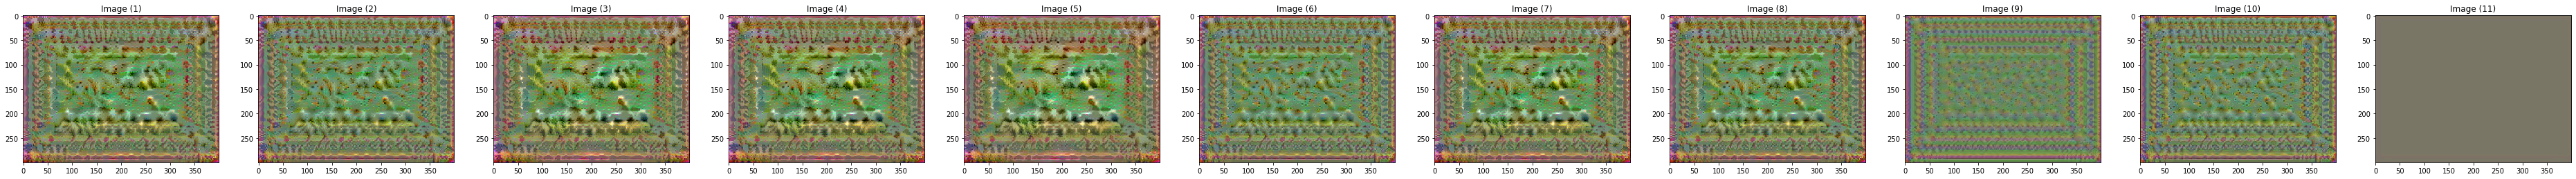

In [61]:
def show_images(images, cols = 1, titles = None):
    """Display a list of images in a single figure with matplotlib.
    
    Parameters
    ---------
    images: List of np.arrays compatible with plt.imshow.
    
    cols (Default = 1): Number of columns in figure (number of rows is 
                        set to np.ceil(n_images/float(cols))).
    
    titles: List of titles corresponding to each image. Must have
            the same length as titles.
    """
    assert((titles is None)or (len(images) == len(titles)))
    n_images = len(images)
    if titles is None: titles = ['Image (%d)' % i for i in range(1,n_images + 1)]
    fig = plt.figure()
    for n, (image, title) in enumerate(zip(images, titles)):
        a = fig.add_subplot(cols, np.ceil(n_images/float(cols)), n + 1)
        if image.ndim == 2:
            plt.gray()
        plt.imshow(image)
        a.set_title(title)
    fig.set_size_inches(np.array(fig.get_size_inches()) * n_images)
    plt.show()
show_images(imgs)    